## Lectura y Limpieza

Los datos usados en este notebook estan en un google drive publico, se puede acceder al rar desde [este link](https://drive.google.com/file/d/18FPmRe_M5ajtjej-8LBExIzvyzW-wPfx/view?usp=sharing).

Descargando y extrayendo del rar debería quedar un estructura asi: `./datasets/precios/20180902/items_preciosclaros_300.csv`

In [1]:
import os
import pandas as pd

In [2]:
# Esta celda demora sus minutitos en ejecutarse
files_to_read = []
root_precios = os.path.join(".","datasets","precios")
for root, dirs, files in os.walk(root_precios):
    for fname in files:
        files_to_read.append(os.path.join(root, fname))

columnas_a_leer = ["fecha_relevamiento", "precio", "producto_id", "sucursal_id"]
precios = pd.concat((pd.read_csv(f, low_memory=False, usecols=columnas_a_leer, parse_dates=[0]) for f in files_to_read))

precios = precios[precios["precio"].notnull()]
precios["sucursal_id"] = precios["sucursal_id"].astype("category")
precios["producto_id"] = precios["producto_id"].astype("category")

# Se ejecuto en scrapper en 5 días distintos, 3 a principio de mes y 2 a final,
# para simplificar cambiamos a inicio y fin de mes.
precios["dia_relevamiento"] = precios["fecha_relevamiento"].dt.strftime('%Y-%m-%d')
precios["dia_relevamiento"] = precios["dia_relevamiento"].replace({'2018-08-31':'2018-09-01', '2018-09-02':'2018-09-01','2018-09-28':'2018-09-29'})

precios = precios.drop("fecha_relevamiento", axis="columns")

## Data Frame Comparativo para Provincia Córdoba

In [3]:
# Esto deberia ser con pivot_table pero por alguna razon se me muere la PC
df_inicio = precios[precios['dia_relevamiento'] == '2018-09-01']
df_inicio.columns = ['precio_inicio_mes', 'producto_id', 'sucursal_id', 'dia_relevamiento']
df_inicio = df_inicio.drop("dia_relevamiento", axis="columns")

df_fin = precios[precios['dia_relevamiento'] == '2018-09-29']
df_fin.columns = ['precio_fin_mes', 'producto_id', 'sucursal_id', 'dia_relevamiento']
df_fin = df_fin.drop("dia_relevamiento", axis="columns")

df_precios = df_inicio.merge(df_fin, left_on=["producto_id", "sucursal_id"], right_on=["producto_id", "sucursal_id"])
df_precios = df_precios[["producto_id", "sucursal_id", "precio_inicio_mes", "precio_fin_mes"]]
df_precios["variacion_mensual"] = round((df_precios["precio_fin_mes"] / df_precios["precio_inicio_mes"]) - 1,2)

# Filtro por quantile 0.95 para sacar outliers y cosas raras
df_precios = df_precios[df_precios.variacion_mensual < 0.33] 

#### Merge con Productos

In [4]:
productos = pd.read_csv("./datasets/productos.csv")
productos = productos.drop_duplicates() # El csv tiene muchos duplicados
df_precios = df_precios.merge(productos, left_on="producto_id", right_on="id")

df_precios["nombre"] = df_precios["nombre"].astype("category")
df_precios["marca"] = df_precios["marca"].astype("category")
df_precios["presentacion"] = df_precios["presentacion"].astype("category")
df_precios.drop("id", axis="columns", inplace=True)

#### Merge con Sucursales de Córdoba

In [5]:
sucursales = pd.read_csv("./datasets/sucursales.csv")
sucursales = sucursales[sucursales.provincia == "AR-X"]
sucursales['sucursal_id'] = sucursales.apply(lambda x: f"{x['comercioId']}-{x['banderaId']}-{x['sucursalId']}", axis=1)

cadenas = pd.read_csv('./datasets/cadenas.csv', usecols=['comercioId', 'banderaId', 'comercioRazonSocial', 'banderaDescripcion'])
cadenas.rename(dict(zip(cadenas.columns[-2:], ['empresa', 'cadena'])), inplace=True, axis="columns")
sucursales = pd.merge(sucursales, cadenas, on=['comercioId', 'banderaId'])
sucursales.drop(['provincia', 'sucursalId', 'comercioId', 'banderaId', "lat", "lng"], axis="columns", inplace=True)
sucursales.head()

df_precios = df_precios.merge(sucursales)

#### Escritura csv limpio

In [6]:
df_precios.to_csv("./datasets/analisis/cordoba_mes_de_septiembre.csv", index=False)

### Analisis

In [7]:
import matplotlib.pyplot as plt

In [8]:
columnas_categoricas = ['producto_id', 'sucursal_id', 'nombre', 'marca', 'presentacion', 'localidad', 'sucursalTipo', 'empresa', 'cadena']
tipo_columnas = ['category'] * len(columnas_categoricas)

col_types = dict(zip(columnas_categoricas, tipo_columnas))
df_precios = pd.read_csv("./datasets/analisis/cordoba_mes_de_septiembre.csv", low_memory=False, dtype=col_types)

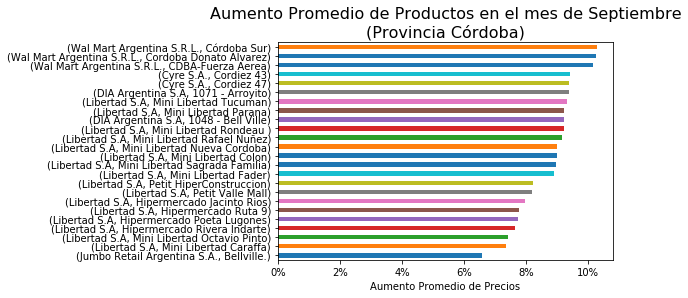

<Figure size 14400x7200 with 0 Axes>

In [9]:
df_precios.groupby(["empresa","sucursalNombre"])["variacion_mensual"].mean().sort_values().plot(kind="barh")
plt.title("Aumento Promedio de Productos en el mes de Septiembre\n(Provincia Córdoba)", size=16)
plt.ylabel("")
plt.xlabel("Aumento Promedio de Precios")
plt.xticks([0,0.02,0.04,0.06,0.08,0.10],["0%","2%","4%", "6%", "8%", "10%"])
plt.figure(figsize=(200,100))
plt.show()

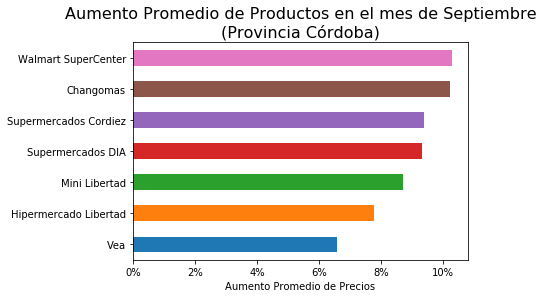

<Figure size 14400x7200 with 0 Axes>

In [10]:
df_precios.groupby(["cadena"])["variacion_mensual"].mean().sort_values().plot(kind="barh")
plt.title("Aumento Promedio de Productos en el mes de Septiembre\n(Provincia Córdoba)", size=16)
plt.ylabel("")
plt.xlabel("Aumento Promedio de Precios")
plt.xticks([0,0.02,0.04,0.06,0.08,0.10],["0%","2%","4%", "6%", "8%", "10%"])
plt.figure(figsize=(200,100))
plt.show()